In [49]:
from numpy.lib.function_base import disp
import numpy as np
import pandas as pd
import missingno as msno
from numba import vectorize
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


attacks = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/shark-attack-assignment/main/attacks.csv", encoding = "utf-8", encoding_errors = 'ignore')
# list_coor_australia = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/shark-attack-assignment/main/list_coor_australia.csv")

attacks.dropna(thresh=3, inplace=True)

attacks.drop(columns=['Date', 'Year', 'Area', 'Location', 'Name', 'Sex ', 'Time', 'Case Number', 'pdf', 'href formula', 'Investigator or Source', 'Case Number.1', 'Case Number.2',
                      'original order', 'Unnamed: 22', 'Unnamed: 23'], inplace=True) # 'Area', 'Location', 'href' toevoegen
attacks.rename(columns={'Species ': 'Species'}, inplace=True)

In [50]:
def valuecounts(df, col):
  return display(df.loc[:, col].value_counts(dropna=False))

def unique(df, col):
  return df.loc[:, col].unique().tolist()

def isnull_sum(df, col):
  return display(df.loc[:, col].isnull().sum())

def typecast(df, col, newtype):
  return display(df.loc[:, col].astype(newtype))

def replace_value(df, col, old_value, new_value, inplace=True):
  return df.loc[: ,col].replace(old_value, new_value, inplace=True)

def mean(df):
  return display(df.isnull().mean())

In [51]:
# 'Type', 'Country', 'Activity', 'Age', 'Injury', 'Fatal (Y/N)', 'Species', ('Area', 'Location', 'href')

# Age
# omdat voor de vraag in de opdracht het verschil tussen kind en volwassene moet kunnen worden bepaald heb ik de
# volgende aanpassingen gedaan.

# In rij 3986 staat een ? ('37, 67, 35, 27, ? & 27')
# Voor deze waarde heb ik het gemiddelde van de groep gekozen nl. 38 print(math.floor(sum([37, 67, 35, 27, 27])/len([37, 67, 35, 27, 27])))
# Dus wordt de complete waarde '37, 67, 35, 27, 38 & 27'# http://sharkattackfile.net/spreadsheets/pdf_directory/1960.06.07-Raytheon.pdf
attacks['Age'][3986] = '37, 67, 35, 27, 38 & 27'
# In rij 5181 staat een ? (? & 14) in de doc lees ik dat het gaat om een man, ik kies 25 als leeftijd
attacks['Age'][5181] = '25, 14'
replace_value(attacks, 'Age', '? & 14', '25, 14') #     http://sharkattackfile.net/spreadsheets/pdf_directory/1924.07.04-boat-NewportBeach.pdf
replace_value(attacks, 'Age', '? & 19', '19, 19') #     https://sharkattackfile.net/spreadsheets/pdf_directory/1967.08.10-Hales-Hislop.pdf
replace_value(attacks, 'Age', '21 & ?', '21, 20') #     http://sharkattackfile.net/spreadsheets/pdf_directory/2001.08.12-Jaimuang.pdf
replace_value(attacks, 'Age', '&', ',')
replace_value(attacks, 'Age', 'X', np.nan)
replace_value(attacks, 'Age', '20?', '20')
replace_value(attacks, 'Age', '20s', '25')
replace_value(attacks, 'Age', '30s', '35')
replace_value(attacks, 'Age', '40s', '45')
replace_value(attacks, 'Age', '50s', '55')
replace_value(attacks, 'Age', '>50', '51')
replace_value(attacks, 'Age', ['60s', '60-s', "60's"], '65')
replace_value(attacks, 'Age', 'mid-20s', '25')
replace_value(attacks, 'Age', 'mid-30s', '35')
replace_value(attacks, 'Age', 'Ca. 33', '33')
replace_value(attacks, 'Age', '"middle-age"', '50')
replace_value(attacks, 'Age', ['Teen', 'teen'], '16')
replace_value(attacks, 'Age', 'Teens', '15,18') # (https://sharkattackfile.net/spreadsheets/pdf_directory/2005.05.02.R-NC-boysAdrift.pdf)
replace_value(attacks, 'Age', ['young', '"young"'], '10')
replace_value(attacks, 'Age', ['adult', '(adult)'], '25')
replace_value(attacks, 'Age', ['elderly', 'Elderly'], '70')
replace_value(attacks, 'Age', '2 to 3 months', '0')
replace_value(attacks, 'Age', '9 months', '0')
replace_value(attacks, 'Age', '18 months', '1')
replace_value(attacks, 'Age', 'Both 11', '11, 11')
replace_value(attacks, 'Age', [' ', '  '], np.nan)
replace_value(attacks, 'Age', 'A.M.', np.nan)
replace_value(attacks, 'Age', 'MAKE LINE GREEN', np.nan)
replace_value(attacks, 'Age', 'F', np.nan)

# 'or' notatie 'a or b' bereken gemiddelde leeftijd
df1 = attacks.loc[:, 'Age'][attacks.loc[:, 'Age'].str.contains('|'.join(['or', 'to']), flags=re.IGNORECASE, na=False)].str.replace('|'.join(['or', 'to']), ',')

# # splitsen
age_or_split = df1.str.split(',', 1, expand=True)

# df['c'] = int(math.floor((df['b'] + df['a']) / 2)) # <SIMPELER EN KORTER<
age_or_split_mean = age_or_split.apply(lambda row: int(math.floor(pd.to_numeric(pd.Series(row.tolist()), errors='coerce').mean())),axis=1)

# df updaten
attacks_age_or = pd.DataFrame()
attacks_age_or.loc[:, 'Age'] = age_or_split_mean
attacks.update(attacks_age_or)

# &
def remove_specific_char(string):
  return re.sub('[&]', ',', string)
attacks = attacks.copy()
attacks['Age'] = attacks['Age'].astype('str').apply(remove_specific_char)

attacks = attacks.copy()
attacks['Age'] = attacks['Age'].str.split(',')
attacks = attacks.explode('Age', ignore_index=True)  # level_0  level=None  .set_index('test') # df = df.reset_index()
attacks = attacks.copy()
attacks['Age'] = attacks['Age'].str.strip()

<ipython-input-51-8acbe2d43860>:44: FutureWarning: The default value of regex will change from True to False in a future version.
  df1 = attacks.loc[:, 'Age'][attacks.loc[:, 'Age'].str.contains('|'.join(['or', 'to']), flags=re.IGNORECASE, na=False)].str.replace('|'.join(['or', 'to']), ',')
<ipython-input-51-8acbe2d43860>:47: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  age_or_split = df1.str.split(',', 1, expand=True)


In [52]:
# Species

# def replace_subs(string, latin, english):
#   return re.sub(latin, english, string)
# Er zijn ook soorten aangeduid in Latijn. Die wilde ik later aanpassen maar toen verschoof de index van de shark_count_sample.

replace_value(attacks, 'Species', '', np.nan)
replace_value(attacks, 'Species', ' ', np.nan)

def remove_specific_chars(string):
  return re.sub('[^a-zA-Z]', ' ', string)
attacks = attacks.copy()
attacks['Species'] = attacks['Species'].astype('str').apply(remove_specific_chars)

pattern = '|'.join([' x ', ' k ', ' to ', ' kg ', ' kg' ' a ', ' rk ', ' mm ', 'm ', ' m ', ' m', ' small ', ' juvenile ', 'Possibly ',
                    ' possibly ', 'Possibily ', 'Possiby ', ' lb ', ' cm ', ' hooked ', ' shot ', ' observed ', ' most were ',
                    ' seen in the vicinity'])
attacks = attacks.copy()
attacks['Species'] = attacks['Species'].str.replace(pattern, ' ', regex=True)  # inplace=True

attacks = attacks.copy()
attacks['Species'] = attacks['Species'].str.replace(r'\s\s+', ' ', regex=True)

def space_end_start(string):
  if string.endswith(" ") and string.startswith(" "):
    string = string[1:-1]
  if string.startswith(" "):
    string = string[1:]
    return string
  if string.endswith(" "):
    string = string[0:-1]
  return string

attacks = attacks.copy()
attacks['Species'] = attacks['Species'].astype('str').apply(space_end_start)

pattern = '|'.join(['Shark involvement doubtful', 'Shark involvement doubtful', 'Shark involvement not cofirmed', 'Shark involvement unconfirmed',
                    'shark involvement probable but not confirmed', 'Shark involvement probable but not confirmed', '	Shark involvement doubtful',
                    'Shark involvement highly doubtful', 'Shark involvement not confirmed', 'Shark involvement prior death could not be determined',
                    'Shark involvement prior death unconfired', 'Shark involvement prior death remains unconfirmed',
                    'Shark involvement prior death unconfirmed', 'Shark involvement prior to death was not confirmed' ,'Shark involvement prior to death unconfirmed',
                    'Shark involvement prior to death suspected but not confirmed', 'Shark involvement prior death was not confirmed', 'Shark involvement prior death suspected but not confirmed',
                    'Shark involvement prior deaths was not confirmed', 'Shark involvement prior deaths unconfirmed',
                    'Shark involvement suspected but not confirmed', 'No shark involvement', 'Questionable',
                    'Questionable incident', 'Invalid', 'Invalid incident', 'Unidentified', 'Unidentified shark', 'Unidentified species', 'Unknown', 'unknown possibly a white shark',
                    'Questionable shark suspected', 'Shark involvement prior death not confirmed', 'Shark involvement prior death still be determined'])
attacks = attacks.copy()
attacks['Species'] = attacks['Species'].replace(pattern, np.nan, regex=True)

def remove_specific_non_species(string):
  search_pattern = re.search(pattern.lower(), string.lower())  #  match resultaat: print(search_pattern.group(0).capitalize())  !
  if search_pattern != None:
    string = np.nan
  return string

attacks = attacks.copy()
attacks['Species'] = attacks['Species'].astype('str').apply(remove_specific_non_species)

replace_value(attacks, 'Species', '', np.nan)


# Op basis van deze sample ga ik NA's toepassen, standaardiseren en categoriseren om de frequentie te bepalen en dan 'counts' herhalen
shark_count_sample = pd.DataFrame
shark_count_sample = attacks['Species'].str.split().value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts')

shark_count_sample = shark_count_sample.copy()
# alle waardes waardes met n > 2
shark_count_sample = shark_count_sample.loc[0:85,:] #['unique_values']

def join_strings(string):
  return ', '.join(str(string))

def try_join(l):
    try:
        return ' '.join(map(str, l))
    except TypeError:
        return np.nan

shark_count_sample['unique_values'] = shark_count_sample['unique_values'].apply(try_join)
shark_count_sample.loc[81, 'unique_values'] = 'Shortfin mako shark'

pattern = '|'.join([' Shark', ' shark', 'shark', 'Shark'])
def sharks(string):
  return re.sub(pattern, '', string)

shark_count_sample = shark_count_sample.copy()
shark_count_sample = shark_count_sample.drop(shark_count_sample[shark_count_sample.unique_values == 'nan'].index) # = nan
shark_count_sample = shark_count_sample.copy()
shark_count_sample = shark_count_sample.drop(index=21).reset_index(drop=True)  # = NaN
# drop Non-species, duplicates
sample_indices = [0, 4, 5, 9, 13 ,16, 18, 20, 22, 23, 25, 26, 30, 31, 32, 33, 34, 35, 37, 38, 39, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 58, 53, 57, 59, 60, 61, 62, 63, 64, 64,
                  68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82]

shark_count_sample = shark_count_sample.copy()
shark_count_sample.drop(index=sample_indices, inplace=True)

shark_count_sample = shark_count_sample.copy()
shark_count_sample['unique_values'] = shark_count_sample['unique_values'].astype('str').apply(sharks)

species_categories = sorted(list(set(shark_count_sample['unique_values'])), key=len, reverse=True)

In [53]:
shark_list_display = pd.DataFrame(data=attacks['Species'].dropna(), index=attacks.index)

def find_species(string):
  pattern = '|'.join(species_categories)
  try:
    if string != 'nan':
      pattern_match = list(map(lambda x: x if re.search(pattern.lower(), x) else None, string.lower().split()))
      if len(list(filter(None, pattern_match))) == 0:
        string = 'nan'
        return string
      else:
        test = ' or '.join(list(filter(None, pattern_match))).capitalize()
        return ' or '.join(list(filter(None, pattern_match))).capitalize() + ' ' + 'shark'
    else:
      return string
  except AttributeError: # np.NaN; numerical nan's vervangen
    string = np.nan
    return string

attacks = attacks.copy()
attacks['Species'] = attacks['Species'].apply(find_species)
replace_value(attacks, 'Species', 'Blue or blue shark', 'Blue shark')       # Blue or blue
replace_value(attacks, 'Species', 'Bull or bull shark', 'Bull shark')       # Bull or bull
replace_value(attacks, 'Species', 'Dusky or dusky shark', 'Dusky shark')    # Dusky or dusky
replace_value(attacks, 'Species', 'Lemon or lemon shark', 'Lemon shark')    # Lemon or lemon
replace_value(attacks, 'Species', 'White or white shark', 'White shark')    # White or white
replace_value(attacks, 'Species', 'Reef or reef shark', 'Reef shark')       # Reef or reef = Reef
replace_value(attacks, 'Species', 'Wobbegongs shark', 'Wobbegong shark')    # Wobbegong = Wobbegongs
replace_value(attacks, 'Species', 'Zambesi shark', 'Bull shark')            # Zambesi = Bull in Africa
replace_value(attacks, 'Species', 'Sandtiger shark', 'Raggedtooth shark')   # Sandtiger = spotted ragged-tooth https://en.wikipedia.org/wiki/Sand_tiger_shark
replace_value(attacks, 'Species', 'Sand shark', 'Sandtiger shark')          # Sand shark = sandtiger https://en.wikipedia.org/wiki/Sand_shark
attacks.loc[6213, 'Species'] = 'Bull shark'                                 # Bull(Zambesi) http://sharkattackfile.net/spreadsheets/pdf_directory/ND-0153-Plough-Higgs.pdf

attacks = attacks.copy()
attacks['Species'] = attacks['Species'].astype('category')

In [54]:
# Injury

replace_value(attacks, 'Injury', 'FATAL ', 'FATAL')
replace_value(attacks, 'Injury', 'Fatal x 2', 'FATAL x 2')
replace_value(attacks, 'Injury', '', np.nan)

FATAL_x_2 = pd.concat([attacks[attacks['Injury'] == 'FATAL x 2']], ignore_index=True)
attacks = pd.concat([attacks, FATAL_x_2], axis=0, ignore_index=True)
FATAL_x_2_4111 = pd.DataFrame(dict(attacks.loc[4111]), index=[0])
attacks = pd.concat([attacks, FATAL_x_2_4111], axis=0, ignore_index=True)
FATAL_x_2_4844 = pd.DataFrame(dict(attacks.loc[4844]), index=[0])
attacks = pd.concat([attacks, FATAL_x_2_4844], axis=0, ignore_index=True)

Bitten_x_2 = pd.DataFrame(dict(attacks.loc[4847]), index=[0])
attacks = pd.concat([attacks, Bitten_x_2], axis=0, ignore_index=True)

replace_value(attacks, 'Injury', 'FATAL x 2', 'FATAL')
replace_value(attacks, 'Injury', 'FATAL X 2, 8 others missing. Survivors fought off sharks & sharks seen biting 2 of the dead. The 39 survivors were rescued by the German freighter Essen',
              'FATAL, 8 others missing. Survivors fought off sharks & sharks seen biting 2 of the dead. The 39 survivors were rescued by the German freighter Essen')
replace_value(attacks, 'Injury', 'FATAL x 2, all other passengers & crew reached shore after a long swim',
              'FATAL, all other passengers & crew reached shore after a long swim')
attacks.loc[[7, 31, 6225, 6231], 'Type'] = 'Provoked'  # Minor injury to foot. PROVOKED INCIDENT, 	FATAL PROVOKED INCIDENTS resp.
attacks.loc[[6135, 4561, 3002, 5450, 6016, 5804, 5092, 1980, 5661, 6153, 1159, 1256, 1713, 4097, 4214], 'Type'] = 'Invalid'
attacks.loc[[285, 787, 2660, 3570, 4082], 'Fatal (Y/N)'] = 'N'
attacks.loc[[6148, 6213], 'Fatal (Y/N)'] = 'Y'
attacks.loc[[1091, 1980, 4561, 3002, 5450, 6016, 5804, 5092, 1159, 1256, 1713, 4097, 4214], 'Fatal (Y/N)'] = np.nan
attacks.loc[5687, 'Injury'] = 'Injured'
attacks.loc[4847, 'Injury'] = 'arm severed'
attacks.loc[6342, 'Injury'] = 'right foot severed'
attacks.loc[[4561, 1385, 2062, 3981, 5156], 'Injury'] = 'Not applicable'
replace_value(attacks, 'Injury', 'FATAL x 2', 'FATAL')
replace_value(attacks, 'Injury', 'No details', np.nan)
attacks.loc[[306, 2660, 3518, 3564, 3570, 3807, 4082, 4717, 6112, 6131, 6211, 2015, 2032, 2676, 4297, 5232, 5844, 4071,
             1701, 5776, 4649, 4071, 4193, 5453, 2635, 2668, 4742], 'Injury'] = np.nan

def replace_subs(string, old, new):
  return re.sub(old, new, string)

attacks = attacks.copy()
old = ['PROVOKED INCIDENT', 'PROVOKED iNCIDENT', 'PROVOKED INICIDENT', 'PROVOKED ATTACK','PROVOKED ACCIDENT']
attacks['Injury'] = attacks['Injury'].astype('str').apply(replace_subs, old = '|'.join(old), new='')

attacks = attacks.copy()
old = ['involvement', 'shark involvement', 'involve', 'involved', 'body not recovered', 'body was not recovered', 'encounter']  # involve, involved
attacks.loc[attacks['Injury'].str.contains('|'.join(old), case=False), 'Injury'] = 'nan' # np.nan  #'nan'

attacks = attacks.copy()
attacks.loc[attacks['Injury'].str.contains('FATAL', case=False), 'Injury'] = 'Not applicable'

attacks = attacks.copy()
old = ['drowning', 'drown', 'scavenging', 'scavenged','post-mortem', 'post mortem']
attacks.loc[attacks['Injury'].str.contains('|'.join(old), case=False), 'Injury'] = 'Not applicable'

attacks = attacks.copy()
old = ['no injury', 'not injured', 'uninjured']
attacks.loc[attacks['Injury'].str.contains('|'.join(old), case=False), 'Injury'] = 'No injury'

# 1. NaN eruit halen, wijzigingen in attacks['Injury'] doen
# 2. Op basis van deze sample ga ik standaardiseren en categoriseren naar items met een hoge frequentie.
# 3. Dan 'counts' herhalen, dan explode, dan stap 2.

# 2.
shark_Injury_count_sample = pd.DataFrame
shark_Injury_count_sample = attacks['Injury'].str.lower().str.split().value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts') # split(',')

# 3.
# attacks['Age'] = attacks['Age'].str.split(',')
shark_Injury_count_sample = shark_Injury_count_sample.copy()
shark_Injury_count_sample = shark_Injury_count_sample.explode('unique_values', ignore_index=True) # .set_index('test') # df = df.reset_index()

# shark_Injury_count_sample = shark_Injury_count_sample.copy()
shark_Injury_count_sample['unique_values'] = shark_Injury_count_sample['unique_values'].astype('str').apply(space_end_start)


adjective = ['slight', 'minor', 'serious', '"serious"', 'severe', 'severely', 'seriously', 'critical']
adjective_map = {'slight': 1, 'minor': 1, 'serious': 70, '"serious"': 70, 'severe': 60, 'severely': 60, 'seriously': 70, 'critical': 80}
verb = ['sustained', 'abraded', 'bruised', 'punctured', 'injured', 'bitten', 'fractured', 'lacerated', 'amputated', 'severed', 'molested']
verb_map = {'sustained': 1, 'abraded': 1, 'bruised': 1, 'punctured': 3, 'injured': 2, 'bitten': 2, 'fractured': 10, 'lacerated': 15, 'amputated': 50, 'severed': 30, 'molested': 15}
noun_body = ['fingernail', 'finger', 'fingers', 'toe', 'toes', 'foot', 'feet', 'hand', 'ankle', 'ankles', 'hands', 'calf', 'shoulder', 'forearm', 'arm', 'arms', 'kneecap', 'knee', 'knees', 'leg', 'thigh', 'femur', 'buttock', 'thighs', 'buttocks', 'legs', 'hip', 'hips', 'abdomen']
noun_body_map = {'fingernail': 0.1,'finger': 0.5, 'fingers': 1, 'toe': 0.5, 'toes': 1, 'foot': 2, 'feet': 4, 'hand': 2, 'ankle': 2, 'ankles': 4, 'hands': 4, 'calf': 3, 'shoulder': 3, 'forearm': 1.5, 'arm': 3, 'arms': 6, 'kneecap': 2, 'knee': 2.5, 'knees': 5, 'leg': 4, 'thigh': 3, 'femur': 3, 'buttock': 2, 'thighs': 6, 'buttocks': 2, 'legs': 8, 'hip': 4, 'hips': 8, 'abdomen': 10}
noun_injury = ['injury', 'bruise', 'wound', 'abrasion', 'bite', 'cut', 'puncture', 'punctures', 'bruises', 'abrasions', 'laceration', 'injuries', 'wounds', 'cuts', 'bites', 'lacerations', '"Serious injuries"', 'amputation']
noun_injury_map = {'no injury': 0, 'injury': 2, 'bruise': 1, 'wound': 2, 'abrasion': 1, 'bite': 2, 'cut': 2, 'puncture': 3, 'punctures': 4, 'bruises': 2, 'abrasions': 2, 'laceration': 15, 'injuries': 4, 'wounds': 4, 'cuts': 4, 'bites': 4, 'lacerations': 30, '"Serious injuries"': 70, 'amputation': 50}

injury_categories = sorted(list(set(adjective + verb + noun_body + noun_injury)), key=len, reverse=True)

def find_injuries(string):
  pattern = '|'.join(injury_categories)
  try:
    if string == 'Not applicable':
      return string
    if string.lower().__contains__('no injury'):
        string = 'No injury'
        return string
    if string != 'nan':
      pattern_match = list(map(lambda x: x if re.search(pattern.lower(), x) else None, string.lower().split()))
      if len(list(filter(None, pattern_match))) == 0:
        string = 'Other'
        return string
      return ' '.join(list(filter(None, pattern_match))).capitalize()
    else:
      return string
  except AttributeError: # np.NaN; numerical nan's vervangen
    string = np.nan
    return string

attacks = attacks.copy()
attacks['Injury'] = attacks['Injury'].apply(find_injuries)

injury_map = {**adjective_map, **verb_map, **noun_body_map, **noun_injury_map}
attacks = attacks.copy()
attacks['Injury'] = attacks['Injury'].apply(lambda x: re.sub(r'\W+', ' ', x))

def find_injury_values(string):
  if string not in ['No injury', 'Not applicable', 'Other', 'nan', np.NaN]:
    pattern_match = list(map(injury_map.get, string.lower().split()))
    int_list = list(filter(None, pattern_match))
  else:
    return string
  return(sum(int_list))

attacks = attacks.copy()
attacks['Injury'] = attacks['Injury'].apply(find_injury_values)

# display(attacks['Injury'].describe())
# count    4337.000000 # mean       15.617385 # std        19.756025
# min         0.100000
# 25%         3.000000
# 50%         6.000000
# 75%        20.000000
# max       151.500000

# Dit zijn de buckets, van 0-3, 3-6 etc.
bins = [0,3,6,20,152]
category = ['Minor','Moderate','Serious','Severe or Critical']
# De namen voor de labels die ik heb gebruikt zijn van de Abbreviated Injury Scale (AIS):
# https://en.wikipedia.org/wiki/Injury_Severity_Score Ik refereer aan de labeling, niet(!) aan de normering.

attacks['AIS'] = attacks['Injury'].apply(pd.to_numeric, errors = 'coerce')
attacks['AIS'] = pd.cut(attacks['AIS'],bins,labels = category)
attacks = attacks.copy()
attacks = attacks.iloc[:, [0, 1, 2, 3, 4, 8, 5, 6, 7]]

No_injury_rows = attacks['Injury'].isin(['No injury'])
attacks = attacks.copy()
attacks['AIS'] = attacks['AIS'].cat.add_categories('No injury')
attacks['AIS'] = attacks['AIS'].mask(No_injury_rows, 'No injury')   # meerdere masks in een syntax kan ook met &, | en ~

Not_applicable_rows = attacks['Injury'].isin(['Not applicable'])
attacks = attacks.copy()
attacks['AIS'] = attacks['AIS'].cat.add_categories('Not applicable')
attacks['AIS'] = attacks['AIS'].mask(Not_applicable_rows, 'Not applicable')

attacks = attacks.copy()
attacks['AIS'] = attacks['AIS'].cat.reorder_categories(['Not applicable', 'No injury', 'Minor','Moderate','Serious','Severe or Critical'], ordered=True)

attacks = attacks.copy()
attacks['Injury'] = attacks['Injury'].astype('str').apply(lambda x: 0 if x == 'No injury' else x)

In [55]:
# Fatal (Y/N)
attacks = attacks.copy()
attacks['Fatal (Y/N)'] = attacks['Fatal (Y/N)'].str.strip()
replace_value(attacks, 'Fatal (Y/N)', 'UNKNOWN', np.nan)

# N       4318
# Y       1392
# NaN      633
# Name: Fatal (Y/N), dtype: int64
# None

In [56]:
# Country
attacks = attacks.copy()
attacks['Country'] = attacks['Country'].str.strip()
attacks = attacks.copy()
attacks['Country'] = attacks['Country'].astype('str').apply(lambda x: x.upper() if x !='nan' else x)
replace_value(attacks, 'Country', 'ST. MAARTIN', 'ST. MARTIN')

attacks = attacks.copy()
attacks['Country'] = attacks['Country'].astype('str').apply(lambda x: replace_subs(x, old='[?]', new=''))

country_names = {'PALESTINIAN TERRITORIES': 'PALESTINE',
                 'ITALY / CROATIA': 'ITALY',
                 'IRAN / IRAQ': 'IRAN',
                 'EQUATORIAL GUINEA / CAMEROON': 'EQUATORIAL GUINEA',
                 'EGYPT / ISRAEL': 'EGYPT',
                 'RED SEA / INDIAN OCEAN': 'RED SEA',
                 'BETWEEN PORTUGAL & INDIA': 'nan',
                 'ASIA': 'nan',
                 'SRI LANKA (SRI LANKA)': 'SRI LANKA',
                 'ANDAMAN / NICOBAR ISLANDAS': 'ANDAMAN & NICOBAR ISLANDS',
                 'ANDAMAN ISLANDS': 'ANDAMAN & NICOBAR ISLANDS',
                 'SOLOMON ISLANDS / VANUATU': 'SOUTH PACIFIC OCEAN',
                 'WESTERN SAMOA': 'AMERICAN SAMOA',
                 'BRITISH ISLES': 'ENGLAND',
                 'FEDERATED STATES OF MICRONESIA': 'MICRONESIA',
                 'ADMIRALTY ISLANDS': 'PAPUA NEW GUINEA',
                 'BRITISH WEST INDIES': 'TURKS & CAICOS',
                 'THE BALKANS': 'SLOVENIA',
                 'MID-PACIFC OCEAN': 'MID-PACIFIC OCEAN',
                 'BAHREIN': 'BAHRAIN',
                 'CEYLON': 'SRI LANKA',
                 'CEYLON (SRI LANKA)': 'SRI LANKA',
                 'OKINAWA': 'JAPAN',
                 'ST HELENA, BRITISH OVERSEAS TERRITORY': 'ST. HELENA, BRITISH OVERSEAS TERRITORY'}

attacks = attacks.copy()
attacks['Country'] = attacks['Country'].replace(country_names, regex=True)

In [57]:
# Type

attacks = attacks.copy()
attacks.loc[attacks['Type'] == 'Sea Disaster', 'Activity'] = 'Sea Disaster'
attacks = attacks.copy()
attacks.loc[attacks['Type'].str.contains(r'(Boating|Boat)', case=False, na=False), 'Activity'] = 'Boating'
attacks.loc[attacks['Type'].str.contains(r'(Invalid|Sea Disaster|Boating|Boat|Questionable|Boatomg|Probabable drowning)', case=False, na=False), 'Type'] = np.nan
warnings.filterwarnings("ignore", message="UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.")

# display(valuecounts(attacks, 'Type'))
# Unprovoked    4599
# NaN           1163
# Provoked       581
# Name: Type, dtype: int64
# None

In [58]:
# Activity

attacks = attacks.copy()
attacks['Activity'] = attacks['Activity'].astype('str').apply(space_end_start)
replace_value(attacks, 'Activity', ['', '.'], 'nan')
replace_value(attacks, 'Activity', 'Hilo', 'Diving')

# shark_activity_count_sample = pd.DataFrame
# shark_activity_count_sample = attacks['Activity'].str.lower().str.split().value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts') # split(',')
# shark_activity_count_sample = shark_activity_count_sample.copy()
# shark_activity_count_sample = shark_activity_count_sample.explode('unique_values', ignore_index=True)
# shark_activity_count_sample['unique_values'] = shark_activity_count_sample['unique_values'].astype('str').apply(space_end_start)
# # display(shark_activity_count_sample.iloc[0:200, :])
# # display(shark_activity_count_sample)

activity_names = {'nan': ['Unknown', 'no details'],
                  'Boating': ['Jet skiing', 'sailing', 'Cruising', 'Pulling anchor', 'escaping', 'Sight-seeing', 'yachtsman'],
                  'Kayaking': ['kayak', 'kayaking', 'Kakaying'],
                  'Canoeing': ['Canoeing', 'Canoe'],
                  'Rowing': ['rowing', 'paddle', 'Paddling', 'Sculling'],
                  'Accident': ['Fell', 'fell overboard', 'Falling', 'oveboard', 'knocked overboard', 'Knocked into the water', 'dropped overboard', 'Swept overboard', 'washed overboard', 'washed off',
                               'swept off', 'Accidentally', 'accident', 'life jacket', 'life-jacket', 'lifejacket', 'life jackets', 'life preserver', 'Diving attempting to retrieve body of drowning victim wedged between rocks',
                               'rescue', 'Rescuing', '"Boat accident"', 'drowning', 'lifesaving', 'Riding floatation device', 'Vehicle plunged over cliff into the water', 'boat swamped'],
                  'War': ['torpedoed', 'torpedoes', 'Battle', 'shelled', 'shot'],
                  'Sea Disaster': ['Sea Disaster', 'shipwrecked', 'wrecked', 'Sinking', 'sank', 'Ditched', 'capsized', 'grounded', 'collided', 'collision', 'overturned', 'deserting', 'explosion', 'Sea Disaster', 'survivors', 'survivor',
                                   'wrecked', 'Loss of the schooner Nomad', 'floating on a', 'floating on an', 'raft', 'adrift', 'refugee', 'illegally', 'caught fire', 's.s. marine',
                                   "'a corsair's boat was overturned'", 'hurricane', 'typhoon', 'storm', 'tsunami', 'tsunamis', 'earthquake'],
                  'Air disaster': ['parachuted', 'crashed', 'Boeing', 'Airforce', 'Air force', 'airlines', 'plane', 'air disaster', 'Aircraft'],
                  'Riding horseback': ['Riding horseback', 'horse', 'horseback', 'horses'],
                  'Walking': ['treading water', 'leaving the water', 'walking', 'wade', 'hiking', 'Wading', '"Crossing the river"', 'Ran into', 'Launching a boat', 'Launching rowboat'],
                  'Standing': ['standing', 'stamding', 'bending over', 'coming ashore'],
                  'Bathing': ['Sunbathing', 'lying', 'Bathing', 'Bather', 'Batin', 'lying prone', 'Sitting', 'Sittting in water', 'In waist-deep water', 'Kneeling', 'dangling foot', 'dangling feet', 'dangling in', 'Floating on his', 'floating on back', 'Floating on air mattress',
                              'on a float', 'Defecating', 'Holding onto an inflatable boat', 'Trailing hand'],
                  'Swimming': ['swimming', 'swim', 'playing', 'Crawling', 'croaching', 'crouching', 'splashing', 'Thrashing', 'Washing', 'Jumping in', 'Jumped into', 'Jumped overboard', 'Jumping', 'Went overboard', 'Jumped off rocks', 'Jumped out of canoe',
                               'dived', 'floating', 'shallows'],
                  'Surfing & skiing': ['surfing', 'Surfng', 'surfboard', 'sailboarding', 'board sailing', 'windsurfing', 'surf race', 'wakeboarding', 'bodyboarding', 'body-boarding', 'body boarding', 'body board',
                                       'boogie boarding', 'boogieboarding', 'skimboarding', 'paddleboarding', 'SUP', 'foil', 'foiling', 'kiteboarding', 'kite-boarding', 'kite boarding', 'Kitesurfing', 'Kite surf', 'bodysurfing', 'Riding waves',
                                       'Paddleskiing', 'paddle-skiing', 'Surf skiing', 'Surf-skiing', 'Water-skiing', 'ski board', 'surfboard', 'stand-up', 'Racing ski', 'board'],
                  'Diving': ['underwater endurance record', 'scuba', 'freediving', 'Free diving', 'Diving', 'dive', 'snorkeling', 'skindiving', 'skin diving', 'Hard hat', 'Hardhat'],
                  'Diving for seafood': ['clams', 'conch', 'clamming', 'Crabbing', 'Dry shelling', 'pearl', 'sponge', 'trochus' 'Angling', 'abalone', 'Hunting', 'Catching', 'gathering', 'Shooting',
                                         'Collecting', 'Harpooned', 'harpoon', 'net', 'Lobstering', 'Oystering', 'prawns', 'trochus'],
                  'Fishing': ['moving shark', 'taking catch', 'Dragging a shark', "'Holding shark's tail'", 'Holding shark', 'pulling shark', 'hauling' ,'return injured shark' ,'land', 'Wrangling a shark', 'pulling up shark', 'picking up shark', 'stranded shark',
                              'beached shark', 'feeding', 'petting', 'feeling', 'touching', 'Teasing a shark', 'Grabbing shark', 'grabbed shark', 'harassing', 'hooked', 'hooking', 'lasso', 'hoisted',
                              'Attacked shark', 'Killing  sharks', 'killing a shark', 'kill a shark', 'finning', 'Fishing', 'Fishing?' 'stuffing', 'reviving', 'netting', 'Fisherman', 'Crayfishing', 'Angling', 'Hunting', 'Catching', 'gathering',
                              'Shooting', 'Collecting', 'netted', 'net', 'netters', 'seine', 'Harpooned', 'harpoon', "Holding shark´s tail", 'spearfishing', 'speared', 'spearing', 'Dynamiting', 'Dynamite', 'removing', 'remove', 'cleaning fish',
                              'cleaning mullet', 'Put foot inside', 'catch a crocodile', 'bichiques', 'opihi', 'slapped', 'ride a shark', 'bait', 'fish trap', 'fish traps', 'Placed hand in', 'stuffing a shark into an automobile'],
                  'Documenting': ['Measuring sharks', 'tagging', 'NSB Meshing', 'anesthetize', 'filming', "'Filming 5' blue shark'", 'motion', 'feature', 'movie', 'camera', 'Photo shoot', 'Photographing', 'photography', 'research'],
                  'Maintenance': ['painting', 'repairing', 'fix', 'rudder', 'check propeller', 'cleaning'],
                  'Suicide': ['suicide'],
                  'Murder': ['thrown overboard', 'murder', 'Murdered', 'homicide']}

activity_names = {key:'|'.join(value) for key, value in activity_names.items()}

attacks = attacks.copy()
for key, value in activity_names.items():
  attacks['Activity'] = attacks['Activity'].mask(attacks['Activity'].str.contains(rf'\b({value})\b', case=False, na=False), key)
  warnings.filterwarnings("ignore", category=UserWarning)

activity_names_keys = [key for key, value in activity_names.items()]

attacks = attacks.copy()
attacks.loc[attacks['Activity'].apply(lambda x: x not in activity_names_keys), 'Activity'] = 'Other'

shark_activity_count_sample = pd.DataFrame
shark_activity_count_sample = attacks['Activity'].str.lower().value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts') # .str.split()
shark_activity_count_sample = shark_activity_count_sample.copy()
# shark_activity_count_sample = shark_activity_count_sample.explode('unique_values', ignore_index=True)
shark_activity_count_sample['unique_values'] = shark_activity_count_sample['unique_values'].astype('str').apply(space_end_start)
# display(shark_activity_count_sample.iloc[0:200, :])
# display(shark_activity_count_sample)

attacks.drop(columns=['href'], inplace=True)

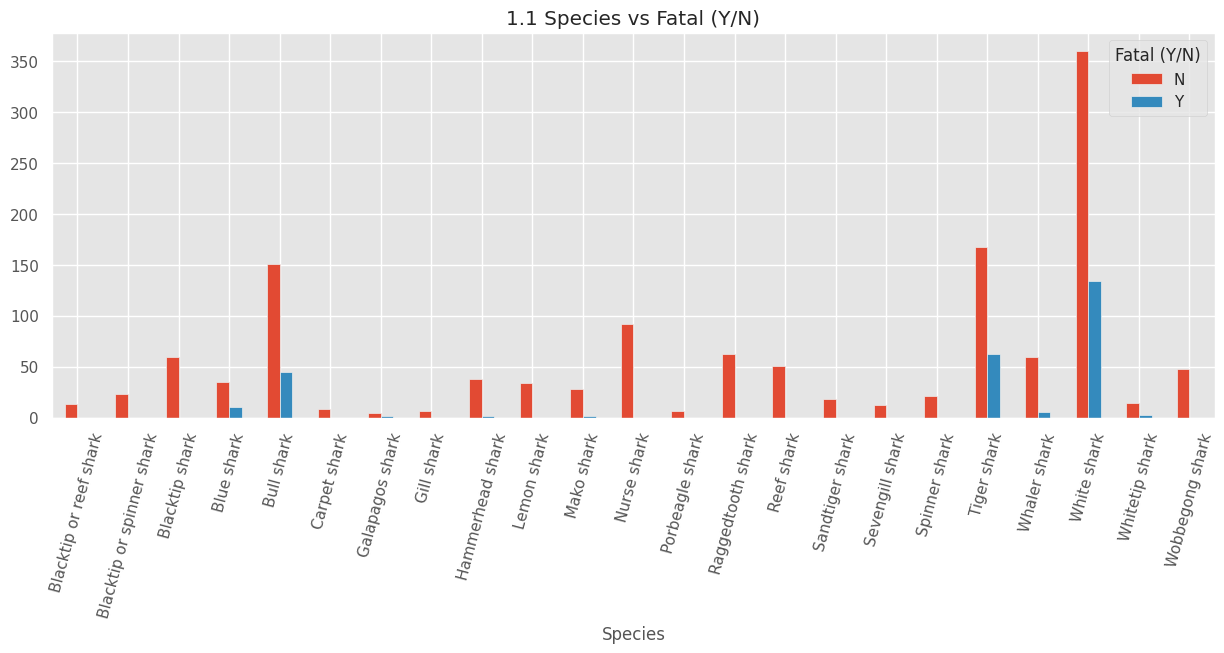

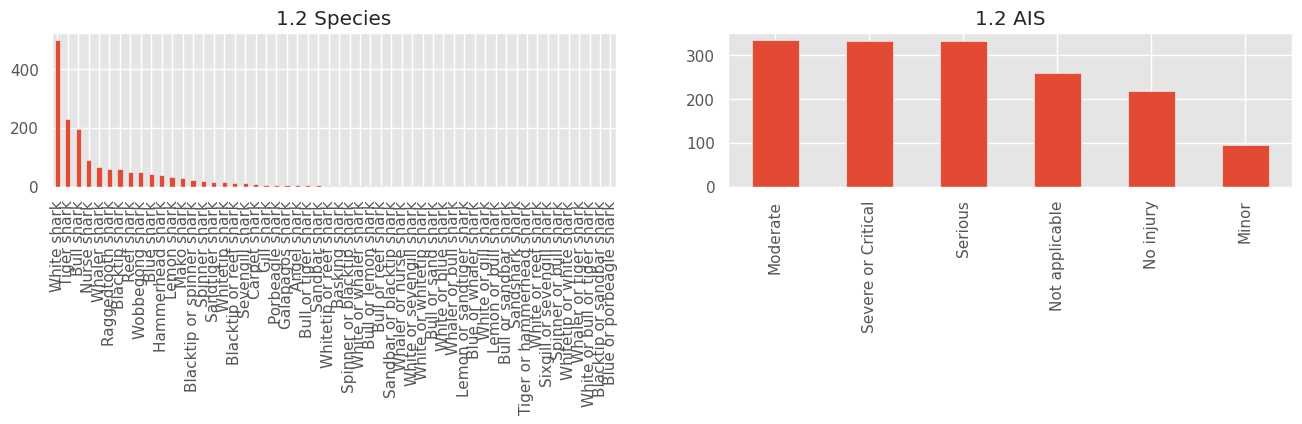

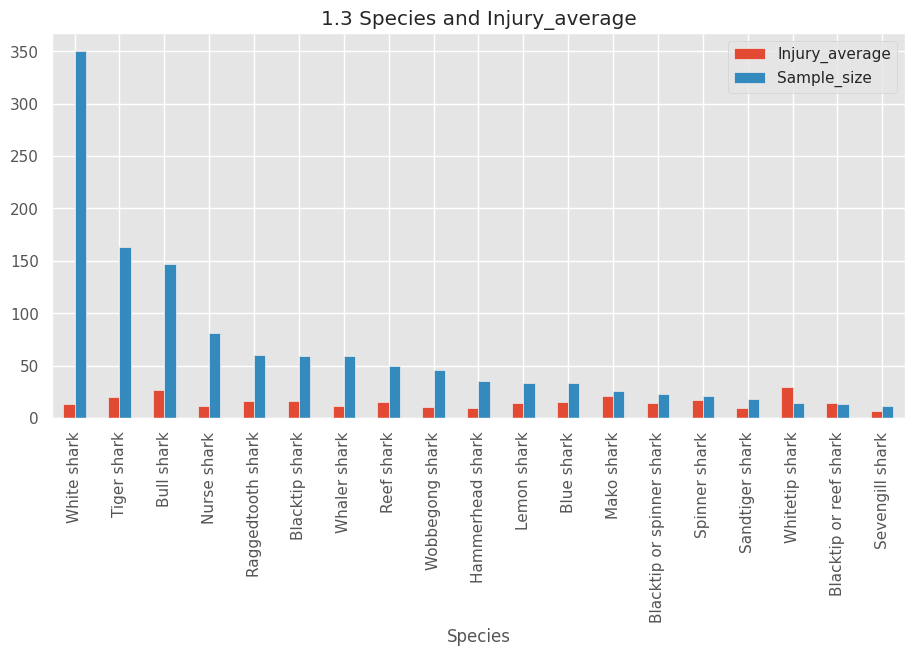

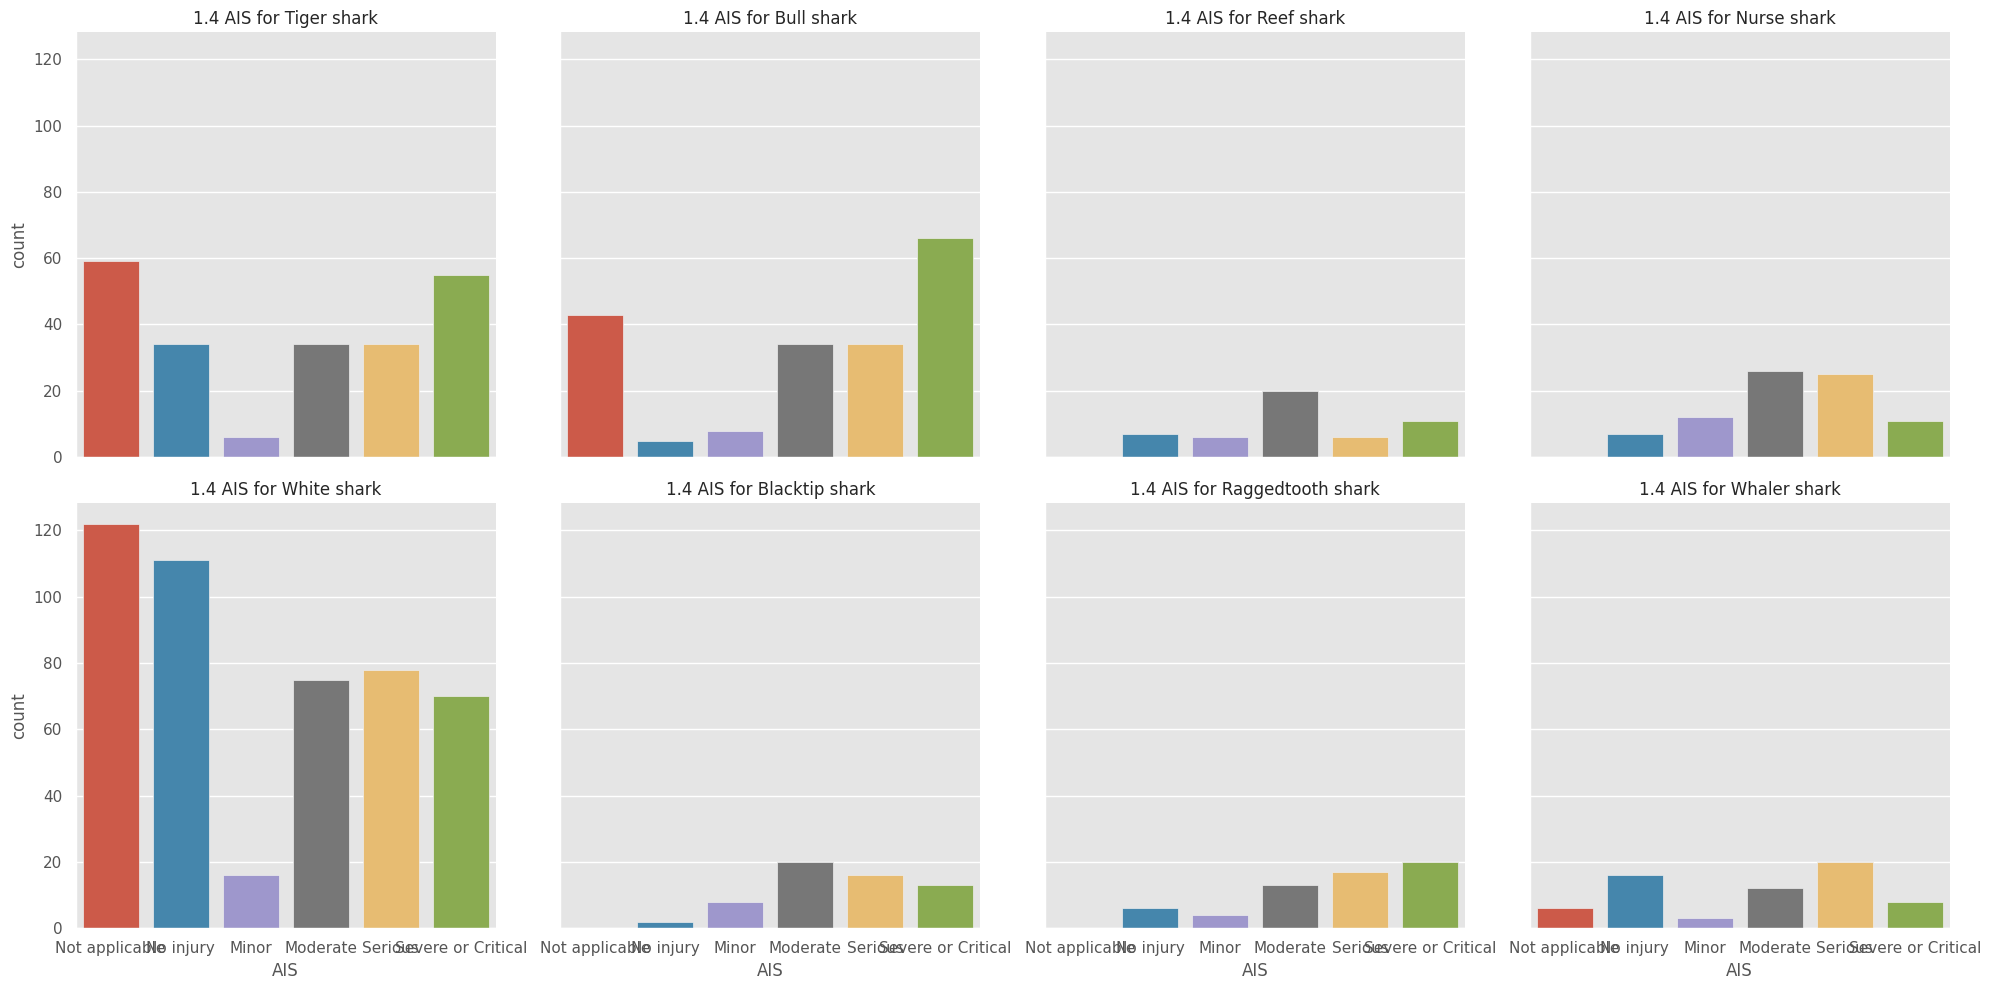

In [59]:
# 1
# What are the most dangerous types of sharks to humans?

replace_value(attacks, 'Species', 'nan', np.nan)
attacks = attacks.copy()
question_one = attacks.loc[~attacks['Type'].isnull() & ~attacks['Species'].isnull(), ['Injury', 'AIS', 'Fatal (Y/N)', 'Species']]

# Grafiek 1.1
def valid_groups(df, col, minimum_size):
  valid_groups = [g for g in set(question_one[col]) if sum(question_one[col] == g) >= minimum_size]
  return question_one[col].isin(valid_groups)

plt.style.use('ggplot')
mask = valid_groups(df=question_one, col='Species', minimum_size=7)
question_one[mask].groupby(['Species','Fatal (Y/N)']).agg(np.size)['AIS'].unstack().plot(kind='bar',
                                                                                         figsize=plt.figaspect(1/3),
                                                                                         title="1.1 Species vs Fatal (Y/N)")  # figsize=(15, 5)
plt.xticks(rotation=75)
plt.show()

# Grafiek 1.2
categorical_features = ["Species", "AIS"]
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(question_one[categorical_features]):
    question_one[categorical_feature].value_counts().plot(kind="bar",
                                                          figsize=plt.figaspect(1/12),
                                                          ax=ax[i]).set_title(f'1.2 {categorical_feature}')
fig.show()

# Grafiek 1.3
mask_species = question_one['Injury'].isin(['nan', 'Other', 'Not applicable'])
question_one_avg = question_one.loc[~mask_species, ['Species', 'Injury']]
question_one_avg = question_one_avg.copy()
question_one_avg['Injury'] = question_one_avg.Injury.astype(float)
question_one_avg['Sample_size'] = question_one_avg.groupby(['Species'])['Injury'].transform('count')
question_one_avg.update(question_one_avg.groupby('Species')['Injury'].transform('mean'))   # UPDATE
question_one_avg.rename(columns={'Injury': 'Injury_average'}, inplace=True)
question_one_avg=question_one_avg.drop_duplicates(subset='Species')
question_one_avg = question_one_avg.sort_values('Sample_size', ascending=False).reset_index(drop=True)
mask_sample_size = question_one_avg['Sample_size'] > 10
question_one_avg = question_one_avg.loc[mask_sample_size, :]
question_one_avg.plot(kind='bar',x='Species',y=['Injury_average', 'Sample_size'], title="1.3 Species and Injury_average")

# Grafiek 1.4
mask = valid_groups(df=question_one, col='Species', minimum_size=50)
plot = sns.catplot(data=question_one[mask], x='AIS', kind='count', col='Species', col_wrap=4)
plot.set_titles("1.4 AIS for {col_name}")
plt.show()

# 1. What are the most dangerous types of sharks to humans?
In grafiek 1.1 zien we dat de White, Tiger en Bull shark het vaakst mensen hebben verwond. De aanvallen van de Bull shark zijn relatief minder vaak dodelijk dan de andere twee. Dan valt op dat van de 20 andere soorten in deze grafiek uitsluitend de Blue en de Wahler shark mensen hebben gedood. Daarbij is de ondergrens voor aantal slachtoffers in deze plot 7 per haaiensoort. Ik denk dsat de laatste observatie niet op toeval berust maar is toe te schrijven aan de aard van de dierensoort.

In grafiek 1.2 zien we het aantal aanvallen per haai en rechts de medische labels. Categorie Moderate, Serious en Severe or Critical hebben de dezelfde frequentie meer dan de categorieen rechts. Ik zou kunnen afleiden dat lichte (Minor) verwondingen minder vaak voorkomen. Kanttekening daarbij is dat de norming voor de scores subjectief is; gebaseerd op mijn ondeskundig oordeel. De dataset bevat ook geen gestandaardiseerde medische gegevens. En ik vind het moeilijk om letsel te objectiveren, maar de aanname is dat dat kan.

In grafiek 1.3 is te zien dat een gemiddelde van de Injury score het hoogst is voor de Whitetip, de Bull en de Mako. Gezien de aantallen zijn de eerste en laatste relatief minder betrouwbaar. Het gemiddelde van de Tiger shark is wel lager dan die van de Bull met een vergelijkbare steekproef. De Bull shark wikipedia geeft aan dat de soort agressief is naar mensen maar een meer precieze onderlinge vergelijking, met bv. de White shark, heb ik niet.

Grafiek 1.4 Hierin heb ik vanaf 50 ongevallen per haaiensoort de frequentie van de AIS-categorieen geplot. In aanvulling op figuur 1.2 geeft deze uitspliting per soort het hoge aantal in de categorie No Injury en Not applicable voor de Witte haai; +- 120 en 110 resp.(daarmee moeten we rekening houden in de linkergrafiek van 1.2). Misschien heeft dit te maken met de mytische status van de soort, beeldvorming in de media en de invloed van documentaires of films over de haai waarin angst voor grote haaien de ondertoon voert. In het visserslatijn wordt een grote vis al snel een haai, en dan natuurlijk een witte want we zijn niet allemaal experts in dat domein.

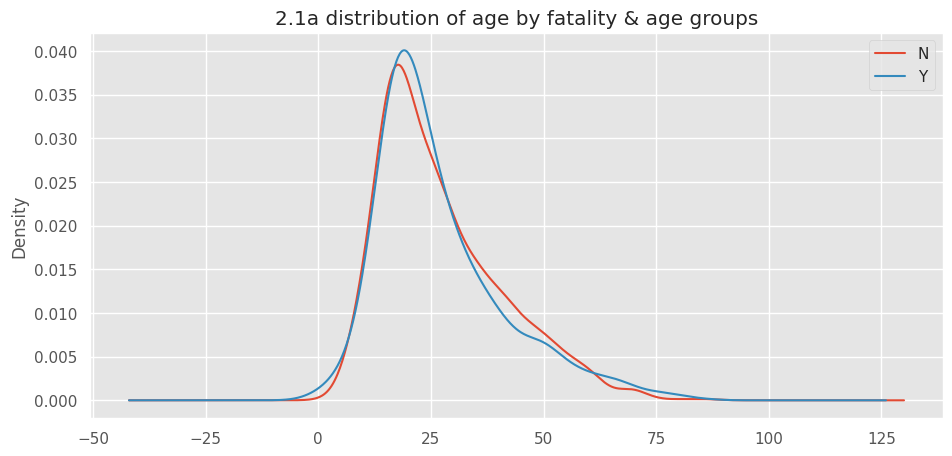

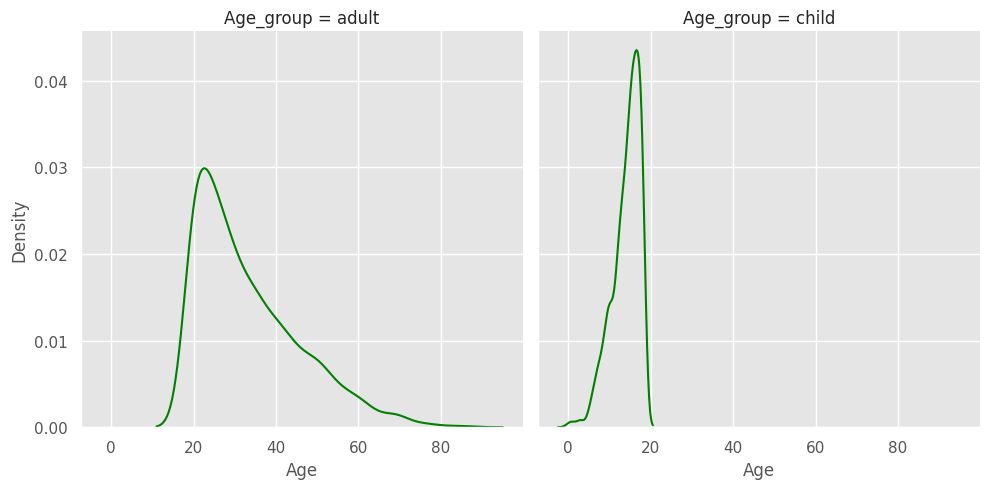

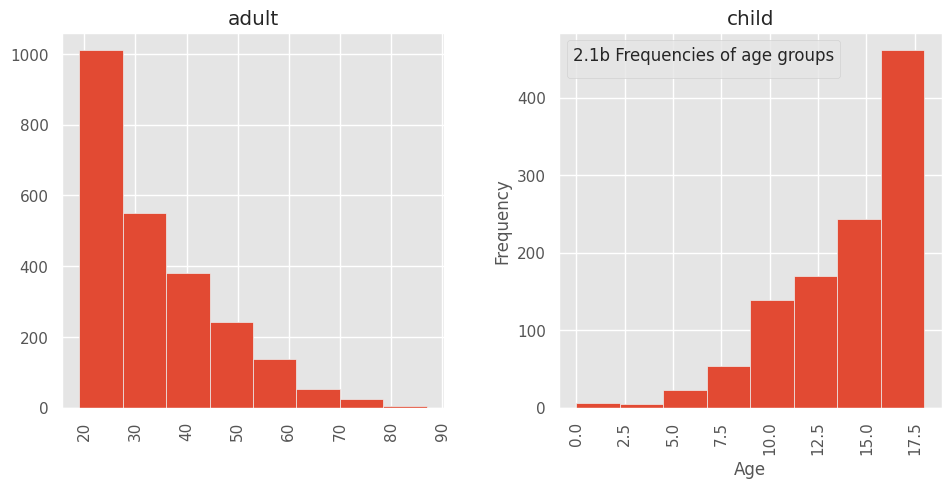

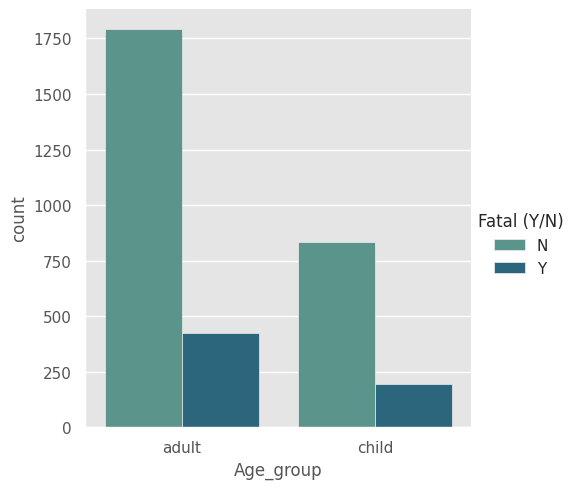

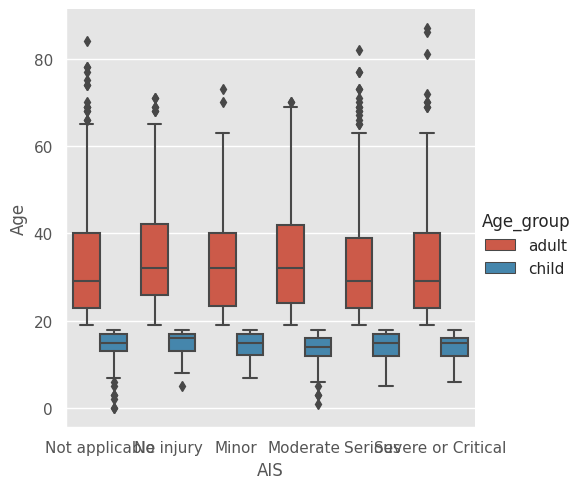

In [44]:
# 2
# Are children more likely to be attacked by sharks? # (Country) Age, Injury, Fatal (Y/N)

# 2.1
replace_value(attacks, 'Age', 'nan', np.nan)
attacks = attacks.copy()
attacks['Age'] = attacks['Age'].astype('float')
def age_group(x):
  if 0 <= x < 19:
    x = 'child'
    return x
  if x >= 19:
    x = 'adult'
  return x

attacks['Age_group'] = attacks['Age'].apply(age_group)
mask_sample_size = question_one_avg['Sample_size'] > 10
question_one_avg = question_one_avg.loc[mask_sample_size, :]

# 2.1a
attacks.groupby('Fatal (Y/N)')['Age'].plot(kind='kde', title="2.1a distribution of age by fatality & age groups", legend=True)
plt.show()
sns.displot(data=attacks, x='Age', col='Age_group', kind="kde", color='green')
attacks = attacks.copy()
attacks = attacks.iloc[:,[0,1,2,3,8,4,5,6,7]]

# 2.1b
plot = attacks.hist('Age', by='Age_group', bins=8)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title='2.1b Frequencies of age groups')

# 2.2
sns.catplot(x='Age_group', kind="count", hue='Fatal (Y/N)', palette="crest", data=attacks)

# 2.3
sns.catplot(x='AIS', y='Age', hue='Age_group', kind="box", data=attacks)

## 2. Are children more likely to be attacked by sharks?
### Grafiek 2.1a & 2.1b
Geen grote verschillen in leeftijd voor dodelijke afloop. Als we inzoomen vanaf 0 jaar begint de de rode lijn iets lager, wat betekent dat in de leeftijd 0 tot 6 à 7 jaar minder dodelijke slachtoffers dan niet-dodelijke zijn gevallen in procenten t.o.v het geheel. Dat is een vaststelling binnen de categorie.
Van de plot per age group is de één scheef naar links en de ander scheef naar rechts. Dus rond de leeftijdsgrens van 19 jaar liggen de frequenties in de data het hoogst. Plot 2.1b laat zien welke frequenties dat zijn.
### 2.2
Per leeftijdsgroep zie geen verschil in de linker en rechter bars bars tov elkaar. Dus wat betreft deze nuance laat ik het bij de vaststelling nav grafiek 2.1a
### 2.3
Hier zien we weer de links/rechts scheefheid in de verdeling maar dan per AIS label. Allemaal scheef, geen uitzondering te zien.

Text(0.5, 1.0, '2.4 World population vs Shark dataset, age groups in %')

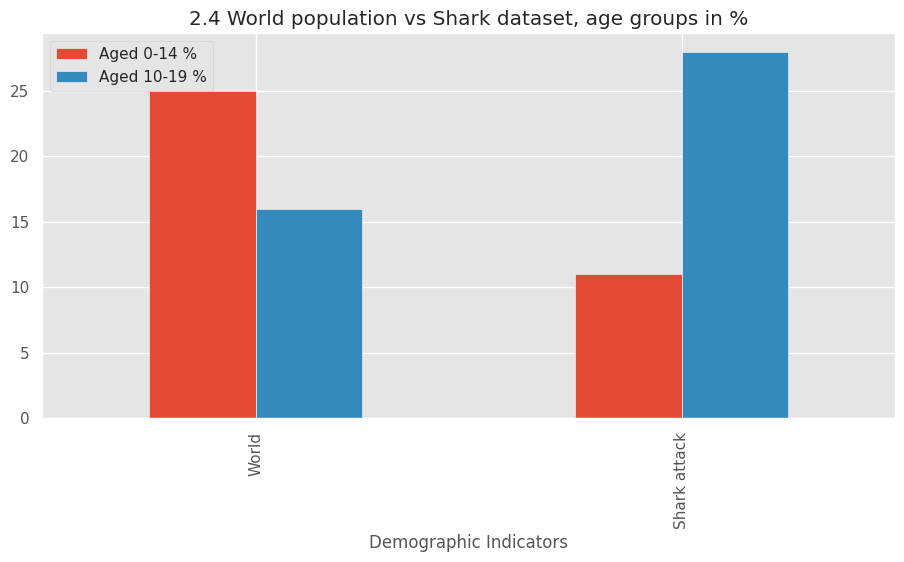

In [45]:
swop = pd.read_excel("https://raw.githubusercontent.com/Whyisthisnamenotavailable/shark-attack-assignment/main/SWOP-Data-2023.xlsx", sheet_name='Demographic_2023')

swop = swop.copy()
swop_pie = swop
swop = swop.iloc[[212,224]][['Demographic Indicators','Unnamed: 4', 'Unnamed: 5']]
swop.rename(columns={'Unnamed: 4': swop.loc[212, 'Unnamed: 4'], 'Unnamed: 5': swop.loc[212, 'Unnamed: 5']}, inplace=True)
swop.drop(212, inplace=True)
swop.rename(columns={'Population aged  0-14, percent': 'Aged 0-14 %', 'Population aged 10-19, percent': 'Aged 10-19 %'}, inplace=True)

swop_pie.loc[3, 'Demographic Indicators'] = swop_pie.loc[2].at['Demographic Indicators'] # 'Countries, territories, other areas'
swop_pie = swop_pie.iloc[6:210, [1,2,4,5]]  #  'Population aged 0-14, percent', 'Population aged 10-19, percent'
swop_pie.rename(columns={'Demographic Indicators': 'Country', 'Unnamed: 2': 'Population in millions',
                         'Unnamed: 4': 'Population aged 0-14, percent', 'Unnamed: 5': 'Population aged 10-19, percent'}, inplace=True)
swop_pie = swop_pie.sort_values('Population in millions', ascending=False)
swop_pie['Population aged 0-14'] = swop_pie['Population aged 0-14, percent']/100 * swop_pie['Population in millions']
swop_pie['Population aged 10-19'] = swop_pie['Population aged 10-19, percent']/100 * swop_pie['Population in millions']
swop_pie.drop(columns=['Population aged 0-14, percent','Population aged 10-19, percent'], inplace=True)

mask_Age_0_14 = attacks['Age'].apply(lambda x: True if 0 <= x < 14 else False)
attacks_Age_0_14 = attacks.loc[mask_Age_0_14, ['Age', 'Country']]  #.count() # 395
mask_Age_10_19 = attacks['Age'].apply(lambda x: True if 10 <= x < 19 else False)
attacks_Age_10_19 = attacks.loc[mask_Age_10_19, ['Age', 'Country']] #.count() # 973
mask_ages_not_null = ~attacks['Age'].isnull()
attacks_Age_not_null = attacks.loc[mask_ages_not_null, ['Age', 'Country']] #.count() # 3496

attacks_Age_0_14_perc = int(round(attacks_Age_0_14['Age'].count() / attacks_Age_not_null['Age'].count() *100))
attacks_Age_0_19_perc = int(round(attacks_Age_10_19['Age'].count() / attacks_Age_not_null['Age'].count() *100))

swop.loc[-1] = ['Shark attack', attacks_Age_0_14_perc, attacks_Age_0_19_perc]  # adding a row
swop.index = swop.index + 1
swop = swop.reset_index(drop=True)
swop = swop.apply(pd.to_numeric, errors='ignore')

# 2.4
swop.plot(x='Demographic Indicators', y=['Aged 0-14 %', 'Aged 10-19 %'], kind="bar")
plt.title('2.4 World population vs Shark dataset, age groups in %')

## 2. Vervolg
### Grafiek 2.4
De ageslices wereldwijd tov de dataset kennen andere getallen. Het percentage 0-14, 'child', links is minder dan de helft qua grote rechts, daarentegen is de groep 'adolescent' van 10-19 veel groter.

### Aannames
Leeftijdsgrens voor kinderen (selection bias) drie vb. VCS 0-18 jaar VN definitie?
Aanname speelt demografie een rol, is constant of een verstorende factor? De aanname bij 'Age' is dat de groep mensen die het water in gaat op plekken waar haaien zwemmen een populatie vertegenwoordigt met dezelfde leeftijdsdistributie als de groep die niet het water in gaat op dezelfde plekken over de tijdspanne van de dataset. Echter ik heb geen data om van deze veronderstelling uit te gaan. Wel heb ik voor 2023 de demografie per land van het UNPF: https://www.unfpa.org/data/world-population-dashboard.
Daarnaast moet men een aanname doen over leeftijdsclassificering, ook vanwege selection bias. Daarbij gebruikt men verschillende definities, denk antropologisch, juridisch of medisch.
*   https://www.nih.gov/nih-style-guide/age
*   https://database.ich.org/sites/default/files/E11_R1_Addendum.pdf
*   https://www.un.org/development/desa/youth/what-we-do/faq.html
*   Article 1 of the United Nations Convention on the Rights of the Child defines ‘children’ as persons up to the age of 18

Vanwege vergelijkbaarheid met data van de UNFPA heb ik gekozen voor jonger dan 19 als definitie hoewel jonger dan 18 vaker wordt gehanteerd. Zij gebruiken een 0-14 voor 'child' en 10-19 voor 'adolescant'.
In vaktermen heet het dan research bias en data en of theorie triangulation. Andere data andere theorie.

<ipython-input-46-f836eaaa68d7>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0] = plt.subplot2grid((3,2),(0,0))
<ipython-input-46-f836eaaa68d7>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[1] = plt.subplot2grid((3,2),(1,0))
<ipython-input-46-f836eaaa68d7>:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot2grid((3,2),(2,0))


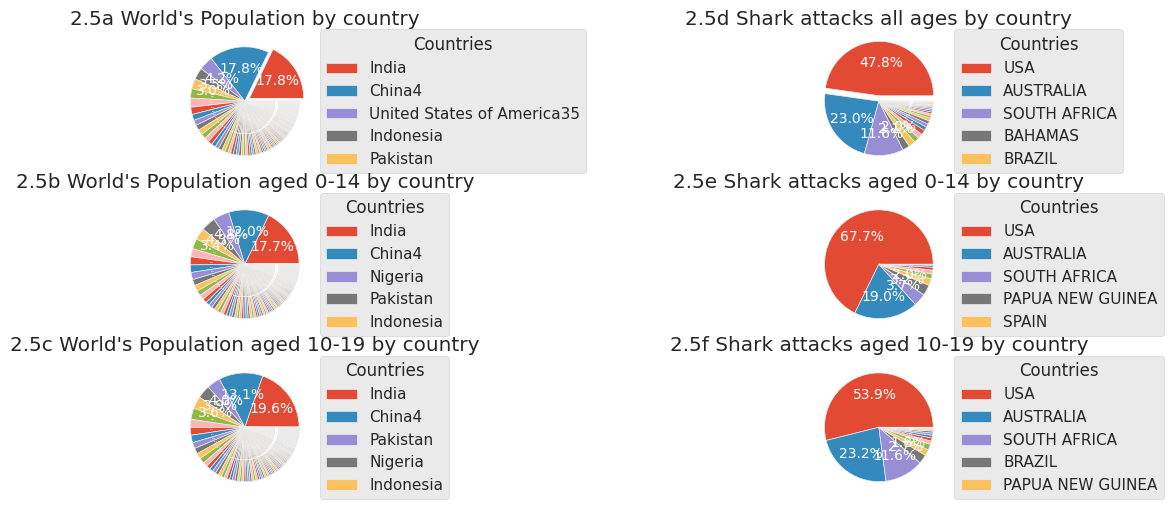

In [46]:
# 2.5
fig, ax = plt.subplots(6, figsize=(15, 6), subplot_kw=dict(aspect="equal"))
#-------------------------------------------------------------------------------
ax[0] = plt.subplot2grid((3,2),(0,0))

data = swop_pie['Population in millions']

explode = tuple([0.1] + [0]* (len(swop_pie['Population in millions'].to_list()) -1))
wedges, texts, autotexts = ax[0].pie(data, explode=explode, autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax[0].legend(wedges, swop_pie['Country'].to_list()[0:5],
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

autotexts = autotexts[5:]
plt.setp(autotexts, size=0, weight="bold")
ax[0].set_title("2.5a World's Population by country")
#-------------------------------------------------------------------------------
ax[1] = plt.subplot2grid((3,2),(1,0))
swop_pie = swop_pie.sort_values('Population aged 0-14', ascending=False)
data = swop_pie['Population aged 0-14']

wedges, texts, autotexts = ax[1].pie(data, autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax[1].legend(wedges, swop_pie['Country'].to_list()[0:5],
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

autotexts = autotexts[5:]
plt.setp(autotexts, size=0, weight="bold")
ax[1].set_title("2.5b World's Population aged 0-14 by country")
# #-------------------------------------------------------------------------------
ax[2] = plt.subplot2grid((3,2),(2,0))
swop_pie = swop_pie.sort_values('Population aged 10-19', ascending=False)
data = swop_pie['Population aged 10-19']

wedges, texts, autotexts = ax[2].pie(data, autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax[2].legend(wedges, swop_pie['Country'].to_list()[0:5],
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

autotexts = autotexts[5:]
plt.setp(autotexts, size=0, weight="bold")
ax[2].set_title("2.5c World's Population aged 10-19 by country")
#-------------------------------------------------------------------------------
ax[3] = plt.subplot2grid((3,2),(0,1))

attacks_Age_not_null['Count'] = attacks_Age_not_null.groupby(['Country']).transform('count')
data = attacks_Age_not_null.drop_duplicates(subset=['Count']).sort_values('Count', ascending=False)

explode = tuple([0.1] + [0]* (len(data['Country'].to_list()) -1))
wedges, texts, autotexts = ax[3].pie(data['Count'].to_list(), explode=explode, autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax[3].legend(wedges, data['Country'].to_list()[0:5],
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

autotexts = autotexts[5:]
plt.setp(autotexts, size=0, weight="bold")
ax[3].set_title('2.5d Shark attacks all ages by country')
#-------------------------------------------------------------------------------
ax[4] = plt.subplot2grid((3,2),(1,1))

attacks_Age_0_14['Count'] = attacks_Age_0_14.groupby(['Country']).transform('count')
data = attacks_Age_0_14.drop_duplicates(subset=['Count']).sort_values('Count', ascending=False)

wedges, texts, autotexts = ax[4].pie(data['Count'].to_list(), autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax[4].legend(wedges, data['Country'].to_list()[0:5],
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

autotexts = autotexts[5:]
plt.setp(autotexts, size=0, weight="bold")
ax[4].set_title('2.5e Shark attacks aged 0-14 by country')
#-------------------------------------------------------------------------------
ax[5] = plt.subplot2grid((3,2),(2,1))

attacks_Age_10_19['Count'] = attacks_Age_10_19.groupby(['Country']).transform('count')
data = attacks_Age_10_19.drop_duplicates(subset=['Count']).sort_values('Count', ascending=False)

wedges, texts, autotexts = ax[5].pie(data['Count'].to_list(), autopct='%1.1f%%',
                                  textprops=dict(color="w"))

ax[5].legend(wedges, data['Country'].to_list()[0:5],
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

autotexts = autotexts[5:]
plt.setp(autotexts, size=0, weight="bold")
ax[5].set_title('2.5f Shark attacks aged 10-19 by country')
#-------------------------------------------------------------------------------
plt.show()

## 2. Slot
### 2.5 Pie plot
Wat ik met 2.6 wil laten zien is de invloed van demografie op de leeftijdsverdeling uit de steekproef als verklaring voor de resultaten in grafiek 2.5. Landen kennen een hogere/ lagere populatie kinderen naar gelang factoren als BNP, ontwikkeling van gezonheidszorg en educatie. De redenering is dan niet het zijn vaker jonge surfers en in die landen wordt meer gesurfd, maar er wonen meer jongeren die nu eenmaal vaker surfen.

*Niet*:
> Leeftijd -> Aanval -> Land

*Maar*:
> Land -> Leeftijd -> Aanval

Om te corrigeren voor demografische gegevens als geslacht, nationaliteit, etniciteit, beroep of in dit geval leeftijd zou je de aantallen per land moeten vermenigvuldigen met de relatieve over/ onderweging per land voor die variabele.

### Conclusie
Is voor kinderen de kans groter om te worden aangevallen door een haai? Waarschijnlijk niet. Per saldo zijn kinderen in de dataset ruimer vertegenwoordigd dan de gemiddelden wereldwijd aangeven. Hoe dat kan is een andere vraag.

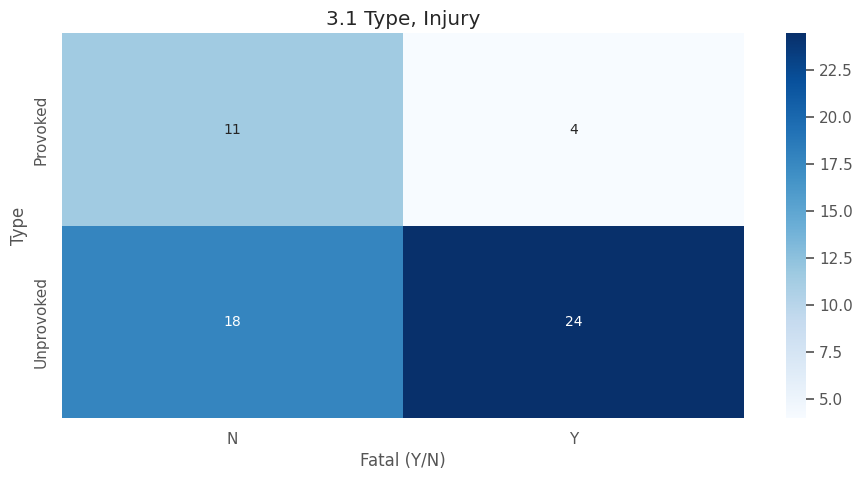

<Axes: title={'center': '3.3 Type and Injury'}, xlabel='Type'>

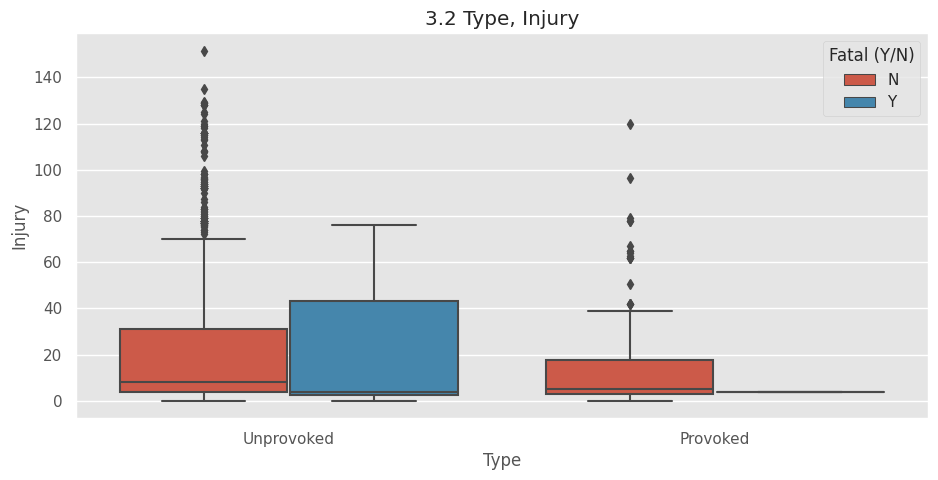

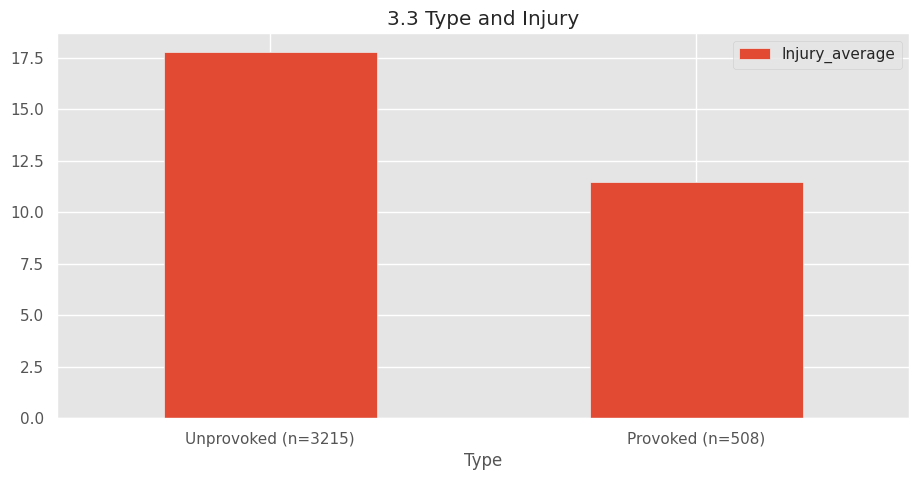

In [47]:
# 3
# Are shark attacks where sharks were provoked more or less dangerous? # Type, Injury, Fatal (Y/N)

question_three = attacks.loc[~attacks['Type'].isnull() & ~attacks['Injury'].isnull() & ~attacks['Fatal (Y/N)'].isnull(), ['Type', 'Injury', 'AIS', 'Fatal (Y/N)']]
question_three = question_three.copy()
question_three['Fatal_binary'] = question_three['Fatal (Y/N)'].replace({'Y' : 1,'N' : 0})

mask_species = question_three['Injury'].isin(['nan', 'Other', 'Not applicable'])
question_three = question_three.loc[~mask_species, ['Fatal (Y/N)', 'Injury', 'Type']]
question_three['Injury'] = question_three['Injury'].apply(pd.to_numeric, errors = 'coerce')

# 3.1
df_heatmap = question_three.pivot_table(values='Injury',index='Type',columns='Fatal (Y/N)',aggfunc=np.mean)
sns.heatmap(df_heatmap,annot=True,cmap="Blues").set_title('3.1 Type, Injury')
plt.show()

# 3.2
sns.boxplot(data=question_three, x='Type', y='Injury', hue='Fatal (Y/N)').set_title('3.2 Type, Injury')

# 3.3
question_three_avg = question_three.copy()
question_three_avg['Injury'] = question_three_avg.Injury.astype(float)
question_three_avg['Sample_size'] = question_three_avg.groupby(['Type'])['Injury'].transform('count')
question_three_avg.update(question_three_avg.groupby('Type')['Injury'].transform('mean'))
question_three_avg.rename(columns={'Injury': 'Injury_average'}, inplace=True)
question_three_avg = question_three_avg.drop_duplicates(subset='Type')
question_three_avg = question_three_avg.sort_values('Sample_size', ascending=False).reset_index(drop=True)
question_three_avg['Type'] = question_three_avg['Type'] + ' (n=' + question_three_avg['Sample_size'].astype('str') + ')'
question_three_avg.plot(kind='bar',x='Type',y='Injury_average', title="3.3 Type and Injury", rot=0)

## 3. Are shark attacks where sharks were provoked more or less dangerous?

### 3.1 Boxplot
Beide typen aanvallen kennen outliers in de letsel indicator, Unprovoked meer dan provoked. Beide typen zijn scheef naar links verdeeld, waarbij in de distributie van provoked de mediaan kleiner is en de bandbreedte van letselscores smaller is en lager ligt. Opvallend is dat uitgelokte aanvallen nauwelijks (om precies te zijn 1) dodelijke afloop hebben gehad. Conclusie non-provocatie van de haai is eerder fataal en zonder provocatie is het letsel ernstiger

### 3.2 Heatmap
Duidelijk mag zijn dat Unprovoked aanvallen slechter aflopen dan provoked.

### 3.3 Barplot
Bevestigd 3.1 Unprovoked vaker fataal, gemiddelde hoger. Sample is wel 6 keer groter dan provoked.

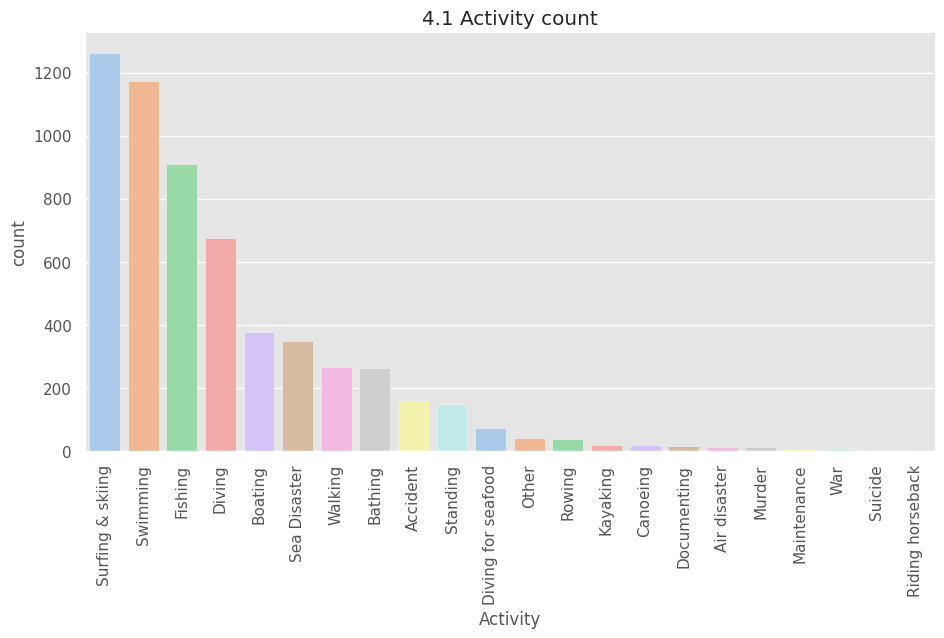

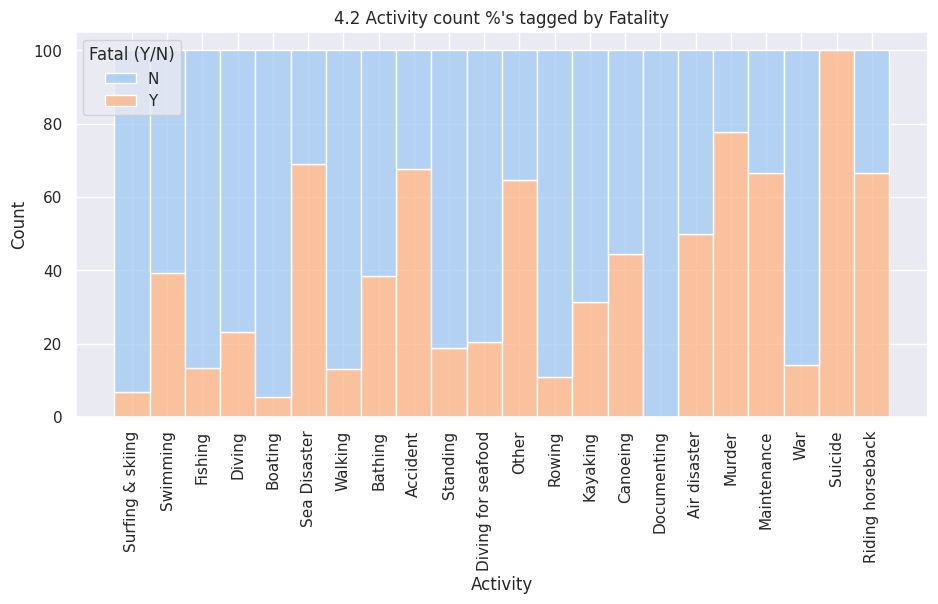

In [48]:
# 4
# Are certain activities more likely to result in a shark attack? # Activity, Injury, Fatal (Y/N)

act_order = attacks.loc[:, 'Activity'].value_counts(dropna=False).index.tolist()
act_order.remove('nan')
sns.catplot(x='Activity', kind='count', order=act_order, palette='pastel', data=attacks, height=5, aspect=2) # .set_title('4.1')   #ok
plt.xticks(rotation=90)
plt.title("4.1 Activity count")
plt.show()

attacks.Activity=pd.Categorical(attacks.Activity,categories=act_order)
plot = attacks.groupby(['Activity'])['Fatal (Y/N)'].value_counts(normalize=True).mul(100).reset_index(name='percentage')
sns.set(rc={'figure.figsize':(11,5)})
sns.histplot(x='Activity', hue='Fatal (Y/N)', weights='percentage', multiple='stack', data=plot, palette='pastel')
plt.title("4.2 Activity count %'s tagged by Fatality")  #ok
plt.xticks(rotation=90)
plt.show()

## 4. Are certain activities more likely to result in a shark attack?

### 4.1 Countplot
In 4.1 zien we telling per activiteit.
Het antwoord op de vraag is dat over het algemeen hoe groter de mogelijkheid voor contact met een haai is, hoe groter het risico dat degene die de activiteit doormaakt, heeft gedragen.

### 4.2 Histplot %.
Sea disaster kent als groep aanzienlijk meer potentiële slachtoffers van haaien, omdat bij rampen nu eenmaal meer mensen tegelijk in het water terecht komen dan bij een enkel ongeval. In het onderscheid per groep is het risico van overlijden door een haai bij confrontatie met een Sea disaster wel terug te zien. Verdrinking en eventuele andere doodsoorzaak zijn voor zover mogelijk dus uitgesloten.